In [1]:
# Importing necessary libraries
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import re
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

In [2]:
# Download NLTK resources (only once)
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/heather/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/heather/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# Connect to SQLite database and load data
connection = sqlite3.connect('/Users/heather/Documents/CodeRepos/project-4/Cleaned_News.db')
data = pd.read_sql_query("SELECT * FROM News_Table", connection)
connection.close()  # Close connection early

In [4]:
# Shuffle dataset
data = data.sample(frac=1).reset_index(drop=True)

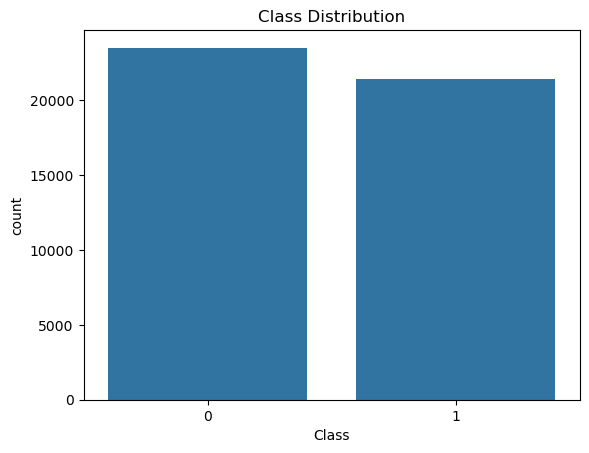

In [5]:
# Visualize class distribution
sns.countplot(data=data, x='Class', order=data['Class'].value_counts().index)
plt.title("Class Distribution")
plt.show()

In [6]:
# Text preprocessing function
def preprocess_text(text_data):
    stop_words = set(stopwords.words('english'))  # Load stopwords once
    return [
        ' '.join(
            token.lower()
            for token in re.sub(r'[^\w\s]', '', sentence).split()
            if token not in stop_words
        )
        for sentence in tqdm(text_data, desc="Preprocessing Text")
    ]

In [7]:
# Apply preprocessing
data['Text'] = preprocess_text(data['Text'])


Preprocessing Text: 100%|██████████| 44919/44919 [00:03<00:00, 11276.09it/s]


In [8]:
# Function to generate WordCloud
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=1600, height=800, random_state=21, max_font_size=110, collocations=False).generate(text)
    plt.figure(figsize=(15, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

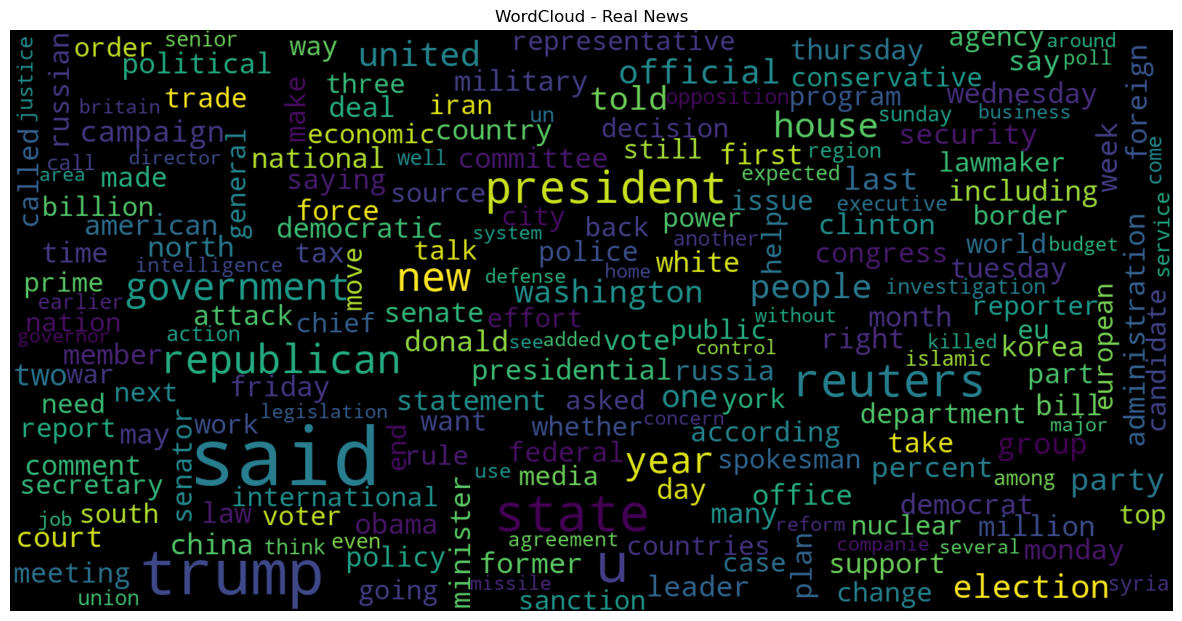

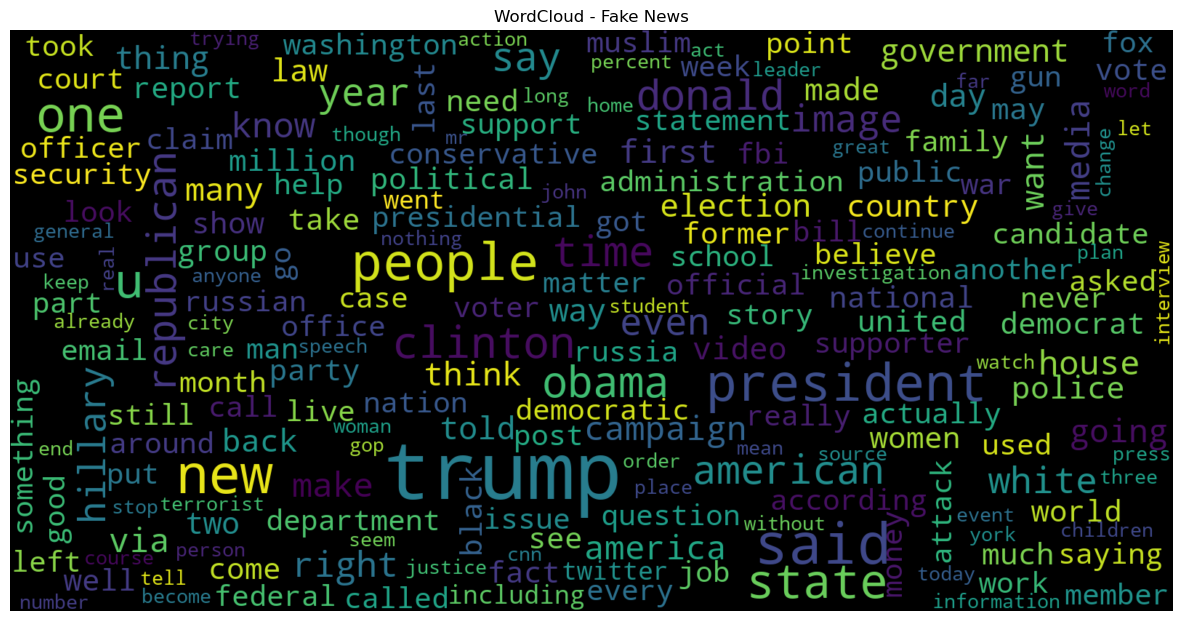

In [9]:
# Generate WordClouds for Real and Fake News
generate_wordcloud(' '.join(data['Text'][data['Class'] == 1]), "WordCloud - Real News")
generate_wordcloud(' '.join(data['Text'][data['Class'] == 0]), "WordCloud - Fake News")

In [10]:
# Function to get top N words
def get_top_n_words(corpus, n=20):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus).sum(axis=0)
    words_freq = sorted([(word, bag_of_words[0, idx]) for word, idx in vec.vocabulary_.items()], key=lambda x: x[1], reverse=True)
    return pd.DataFrame(words_freq[:n], columns=['Word', 'Count'])


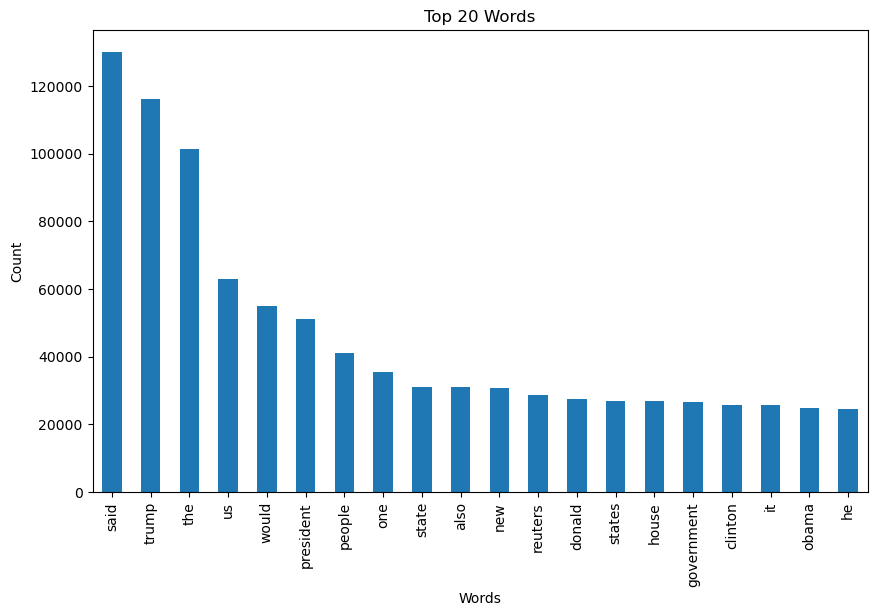

In [11]:
# Plot top 20 words
top_words = get_top_n_words(data['Text'])
top_words.set_index('Word')['Count'].plot(kind='bar', figsize=(10, 6), title="Top 20 Words", xlabel="Words", ylabel="Count")
plt.show()

In [12]:
# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(data['Text'], data['Class'], test_size=0.25, random_state=42)

In [13]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer()
x_train = vectorizer.fit_transform(x_train)
x_test = vectorizer.transform(x_test)

In [14]:
# Train and evaluate models
def train_and_evaluate(model, model_name):
    model.fit(x_train, y_train)
    train_acc = accuracy_score(y_train, model.predict(x_train))
    test_acc = accuracy_score(y_test, model.predict(x_test))
    print(f"{model_name} - Training Accuracy: {train_acc:.2f}, Testing Accuracy: {test_acc:.2f}")
    return model

In [15]:
# Logistic Regression
train_and_evaluate(LogisticRegression(), "Logistic Regression")

Logistic Regression - Training Accuracy: 0.99, Testing Accuracy: 0.99


LogisticRegression()

In [16]:
# Decision Tree
dt_model = train_and_evaluate(DecisionTreeClassifier(), "Decision Tree")

Decision Tree - Training Accuracy: 1.00, Testing Accuracy: 1.00


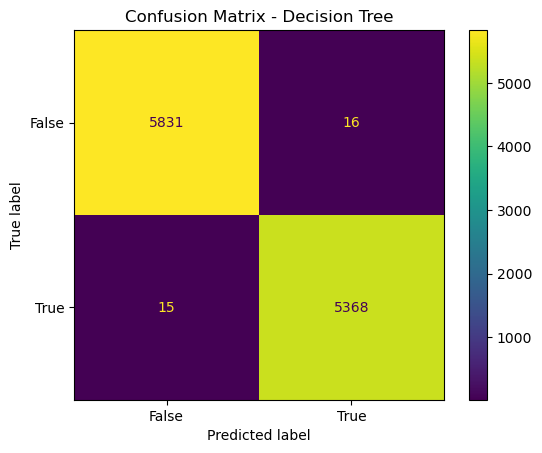

In [17]:
# Confusion Matrix for Decision Tree
cm = confusion_matrix(y_test, dt_model.predict(x_test))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[False, True]).plot()
plt.title("Confusion Matrix - Decision Tree")
plt.show()